In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np

import librosa as lr
from librosa.display import specshow

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax

from sklearn.model_selection import train_test_split

from glob import glob

In [0]:
## load some data
path_file_1 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/0_jackson_0.wav'
path_file_2 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/0_yweweler_47.wav'
path_file_3 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/1_theo_31.wav'

signal_1, rate = lr.load(path_file_1)
signal_2, _ = lr.load(path_file_2)
signal_3, _ = lr.load(path_file_3)

In [102]:
print(signal_1.shape)
print(signal_2.shape)
print(signal_3.shape)

(14190,)
(7608,)
(16847,)


In [0]:
## plot amplitude audio signal

def plot_one_audio(audio, rate, label, more_precise=False):
    '''
    Plot one audio according to the floating audio vector and the rate
    '''
    if (more_precise):
        audio = audio[1000:3000]
    time = np.arange(len(audio)) / rate ## time vector
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    plt.title("Audio of: {}".format(label))
    ax.set(xlabel='Time (s)', ylabel='Amplitude')
    plt.show()

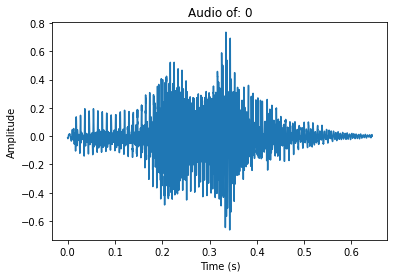

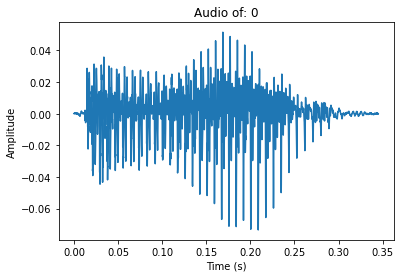

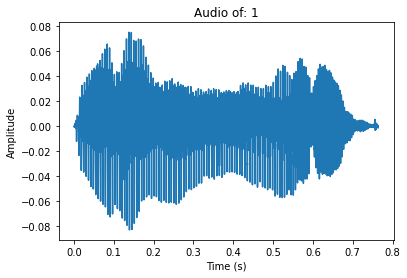

In [104]:
plot_one_audio(signal_1, rate, 0)
plot_one_audio(signal_2, rate, 0)
plot_one_audio(signal_3, rate, 1)

In [0]:
## display spectrum
def plot_spec(signal, rate, label):
    '''
    Plot the Linear Frequency Spectrum
    '''
    spec = lr.feature.melspectrogram(y=signal, sr=rate, n_fft=2048, hop_length=512)
    D = lr.amplitude_to_db(spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    specshow(D, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f Intensity dB')
    plt.title('Linear-frequency power spectrogram for label {}'.format(label))
    plt.tight_layout()
    plt.show()

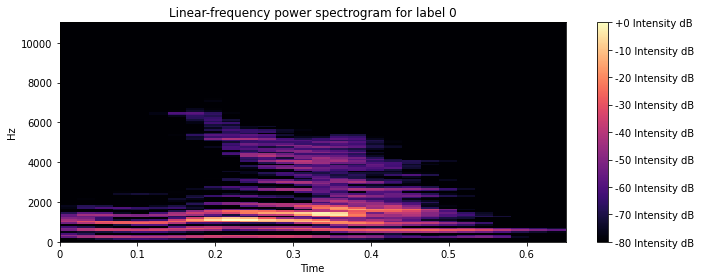

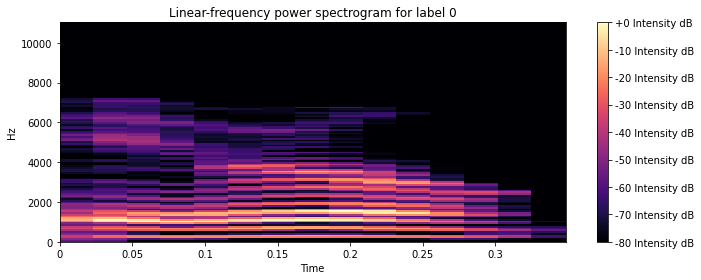

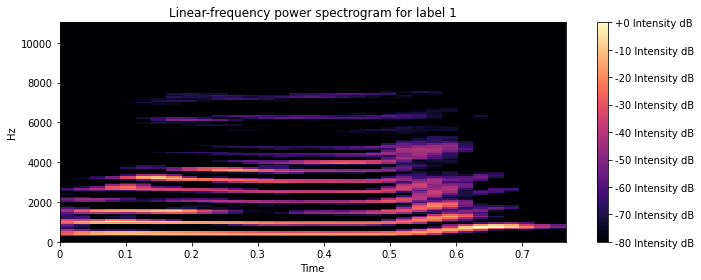

In [106]:
plot_spec(signal_1, rate, 0)
plot_spec(signal_2, rate, 0)
plot_spec(signal_3, rate, 1)

In [0]:
def predict(model, X_test, y_test, speakers):
  '''
  Make prediction
  '''
  for i in range(y_test.shape[0]):
    tmp = X_test[i]
    pred = model.predict(np.reshape(tmp, (1, 1, tmp.shape[-1])))
    p = np.argmax(pred)
    print("Pred: '{}'    Expected: '{}'".format(speakers[p], speakers[p]))

In [0]:
def load_data_mfccs(path, n_mfccs):
  '''
  Load the data from files
  Get the mfccs from each file
  And build X_train, y_train, X_test, y_test
  '''

  files = glob(path)
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  X, y = np.zeros((2000, n_mfccs)), np.zeros(2000)

  for idx, file_path in enumerate(files):
    ## load the signal
    signal, rate = lr.load(file_path)

    ## get the mfccs
    mfccs = lr.feature.mfcc(y=signal, sr=rate, n_mfcc=n_mfccs)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    if idx % 100 == 0:
      print("mfccs extracted for data number {}".format(idx))

    ## get the label
    file_name = file_path.split('/')[-1] ## get the file name
    speaker_name = file_name.split('_')[1] ## get the speaker name
    label = speakers.index(speaker_name) ## get the label

    X[idx] = mfccs_processed
    y[idx] = label

  ## split data for training and testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
  return X_train, y_train, X_test, y_test, rate

In [118]:
path = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/*.wav'
X_train, y_train, X_test, y_test, rate = load_data_mfccs(path, 40)

mfccs extracted for data number 0
mfccs extracted for data number 100
mfccs extracted for data number 200
mfccs extracted for data number 300
mfccs extracted for data number 400
mfccs extracted for data number 500
mfccs extracted for data number 600
mfccs extracted for data number 700
mfccs extracted for data number 800
mfccs extracted for data number 900
mfccs extracted for data number 1000
mfccs extracted for data number 1100
mfccs extracted for data number 1200
mfccs extracted for data number 1300
mfccs extracted for data number 1400
mfccs extracted for data number 1500
mfccs extracted for data number 1600
mfccs extracted for data number 1700
mfccs extracted for data number 1800
mfccs extracted for data number 1900


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [123]:
print("Training data shape: {}".format(X_train.shape))
print("One training data shape: {}".format(X_train[0].shape))
print("Training label shape: {}".format(y_train.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1600, 1, 40)
One training data shape: (1, 40)
Training label shape: (1600,)
Test data shape: (400, 1, 40)
Test label shape: (400,)


In [0]:
## define our model
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(1,40)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

In [125]:
## summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 1, 512)            20992     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_35 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_36 (Dense)             (None, 1, 128)          

## Dense model
### Optimizer: Adam
### loss: categorical crossentropy
### Input: mfccs parameters of the signal

In [0]:
adm = Adam(lr=0.01)
model.compile(optimizer=adm, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [128]:
## fit our model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 0.3483 - acc: 0.8669 - val_loss: 6.3819 - val_acc: 0.4825
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1237 - acc: 0.9531 - val_loss: 0.0430 - val_acc: 0.9900
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1395 - acc: 0.9531 - val_loss: 0.0598 - val_acc: 0.9875
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1375 - acc: 0.9569 - val_loss: 1.1490 - val_acc: 0.6700
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1636 - acc: 0.9388 - val_loss: 1.2784 - val_acc: 0.6725
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1482 - acc: 0.9413 - val_loss: 3.9105 - val_acc: 0.5300
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1453 - acc: 0.9469 - val_loss: 6.8831 - val_acc: 0.4625
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: 0.1105 - 

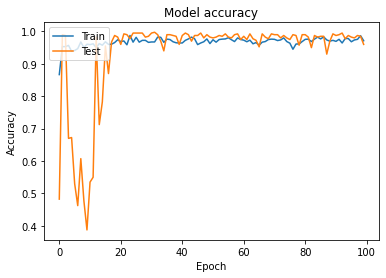

In [129]:
# evaluate our model

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [131]:
model.evaluate(X_test, y_test, verbose=2)

13/13 - 0s - loss: 0.1900 - acc: 0.9600


[0.18997961282730103, 0.9599999785423279]

In [132]:
## make some prediction
speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
predict(model, X_test[:20], y_test[:20], speakers)

Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'theo'    Expected: 'theo'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'theo'    Expected: 'theo'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'jackson'    Expected: 'jackson'
